In [47]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.messages import SystemMessage, HumanMessage
import operator

In [73]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    feedback: str
    evaluation: Literal["approved", "needs_improvement"]
    iterations: int
    max_iterations: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]


In [4]:
load_dotenv()

True

In [5]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [74]:
def tweet_generator(state: TweetState) -> TweetState:
    messages = [SystemMessage(content="You are a funny and clever Twitter/X influencer."),
                HumanMessage(content=f"""
                Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

                Rules:
                - Do NOT use question-answer format.
                - Max 280 characters.
                - Use observational humor, irony, sarcasm, or cultural references.
                - Think in meme logic, punchlines, or relatable takes.
                - Use simple, day to day english
                """)]

    tweet = llm.invoke(messages).content

    return {
        "tweet": tweet,
        "tweet_history": [tweet],  # ✅ delta only
        "iterations": state["iterations"] + 1
    }

In [36]:
class eval_output(BaseModel):
    feedback: str = Field(description='the feedback on the tweet')
    evaluation: Literal["approved", "needs_improvement"] = Field(description='final verdict on the tweet')

eval_llm = llm.with_structured_output(eval_output)

In [75]:
def tweet_evaluator(state: TweetState) -> TweetState:
    messages = [SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets."),
                HumanMessage(content=f"""
                Evaluate the following tweet:

                Tweet: "{state['tweet']}"

                Use the criteria below to evaluate the tweet:

                1. Originality 🧠 Is this fresh, or have you seen it a hundred times before?
                2. Humor 😂 Did it genuinely make you smile, laugh, or chuckle?
                3. Punchiness ⚡ Is it short, sharp, and scroll-stopping?
                4. Virality Potential 🔁 Would people retweet or share it?
                5. Format 📏 Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

                Auto-reject if:
                - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
                - It exceeds 280 characters
                - It reads like a traditional setup-punchline joke
                - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpiece")

                ### Respond ONLY in structured format:
                - evaluation: "approved" or "needs_improvement"
                - feedback: One paragraph explaining the strengths and weaknesses
                """)]
    result = eval_llm.invoke(messages)
    feedback = result.feedback
    evaluation = result.evaluation

    return {
        "feedback": feedback,
        "evaluation": evaluation,
        "feedback_history": [feedback],  # ✅ delta only
        "iterations": state["iterations"] + 1
    }

In [76]:
def tweet_optimiser(state: TweetState) -> TweetState:
    messages = [SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
                HumanMessage(content=f"""
                Improve the tweet based on this feedback:
                "{state['feedback']}"

                Topic: "{state['topic']}"
                Original Tweet:
                {state['tweet']}

                Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
                """)]    

    tweet = llm.invoke(messages).content

    return {
        "tweet": tweet,
        "tweet_history": [tweet],  # ✅ delta only
        "iterations": state["iterations"] + 1}

In [39]:
def router(state: TweetState):
    if state['iterations'] > state['max_iterations'] or state['evaluation'] == 'approved':
        return "approved"
    else:
        return "needs improvement"

In [77]:
graph = StateGraph(TweetState)

graph.add_node("generator", tweet_generator)
graph.add_node("evaluator", tweet_evaluator)
graph.add_node("optimiser", tweet_optimiser)

graph.add_edge(START, "generator")
graph.add_edge("generator", "evaluator")
graph.add_conditional_edges("evaluator", router, {'needs improvement': 'optimiser', 'approved': END})
graph.add_edge("optimiser", "evaluator")


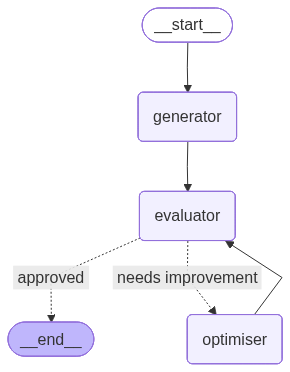

In [78]:
workflow = graph.compile()
workflow

In [79]:
initial_state = {'topic': 'Oscars 2026', 'iterations': 1, 'max_iterations': 5}

final_state = workflow.invoke(initial_state)
print(final_state)

{'topic': 'Oscars 2026', 'tweet': 'Oscar predictions for 2026: Best Picture? Definitely the film where every character is either a superhero or a talking animal—my childhood dreams and adult nightmares, colliding with a box office boom. 😂 Best Score? Just the sound of my soul fading while I scroll through memes. 🦸\u200d♂️🎬 #Oscars2026', 'feedback': "This tweet displays a fair amount of originality by satirizing the trend of superhero and talking animal movies while cleverly intertwining nostalgia and existential dread. However, the humor doesn't land as effectively as it could; the emojis, while colorful, detract from the punchiness, making it feel slightly overextended rather than sharp and concise. The tweet is well-formed and under the character limit, but it lacks the immediate impact needed for scroll-stopping content, and the punchline regarding the soul fading feels flat rather than resonant. Overall, the tweet needs refinement to achieve stronger engagement and impact.", 'evalu

In [80]:
mylist = list(final_state["tweet_history"])


In [82]:
mylist

['Oscar predictions for 2026: Best Picture goes to that one movie where everyone is either a superhero or a talking animal. Best Original Score? The sound of my sanity slowly fading while I scroll through all the "just got nominated" memes. 🎬🏆#Oscars2026',
 'Oscar predictions for 2026: Best Picture goes to the movie where every character is a superhero or a talking animal—basically my childhood dreams and adult nightmares colliding. 🦸\u200d♂️🐾 Best Original Score? Just the sound of my hopes fading while I scroll through memes. 🎬🏆 #Oscars2026',
 'Oscar predictions for 2026: Best Picture? Definitely the film where every character is either a superhero or a talking animal—my childhood dreams and adult nightmares, colliding with a box office boom. 😂 Best Score? Just the sound of my soul fading while I scroll through memes. 🦸\u200d♂️🎬 #Oscars2026']